In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [2]:
from src.data_processing.dataset import iScatDataset
from src.data_processing.utils import Utils
import torch
import numpy as np
import matplotlib.pyplot as plt
DEVICE= 'cuda:12' if torch.cuda.is_available() else 'cpu'
data_path_1 = os.path.join('dataset', '2024_11_11', 'Metasurface', 'Chip_02')
data_path_2 = os.path.join('dataset', '2024_11_12', 'Metasurface', 'Chip_01')
image_paths= []
target_paths=[]
image_indicies = 12
for data_path in [data_path_1,data_path_2]:
    i,t = Utils.get_data_paths(data_path,'Brightfield',image_indicies )
    image_paths.extend(i)
    target_paths.extend(t)

In [79]:
image_size=256
fluo_masks_indices=[0]
seg_method = "comdet"
normalize=False
train_dataset = iScatDataset(image_paths[:-2], target_paths[:-2], preload_image=True,image_size = (image_size,image_size),apply_augmentation=True,normalize=normalize,device=DEVICE,fluo_masks_indices=fluo_masks_indices,seg_method=seg_method)
valid_dataset = iScatDataset(image_paths[-2:],target_paths[-2:],preload_image=True,image_size = (image_size,image_size),apply_augmentation=False,normalize=normalize,device=DEVICE,fluo_masks_indices=fluo_masks_indices,seg_method=seg_method)
MEAN = train_dataset.images.mean(dim=(0,2,3),keepdim=True)
STD = train_dataset.images.std(dim=(0,2,3),keepdim=True)

Loading images to Memory: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


In [102]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import Normalize
batch_size=128
def create_dataloaders(test_dataset, batch_size=4):
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return val_loader
val_loader = create_dataloaders(valid_dataset, batch_size=batch_size)

In [103]:
n_samples = 10
samples = [valid_dataset[i] for i in range(n_samples)]
test_batch = next(iter(val_loader))

In [61]:
experiments_paths = (
    'experiments/runs/UNet_Brightfield_2025-01-12_18-05-44',
    'experiments/runs/UNet_Brightfield_2025-01-12_19-09-15',
    'experiments/runs/UNet_Brightfield_2025-01-12_20-27-14')

In [104]:
from src.models.Unet import UNet
def load_model(path, num_classes=2,device=DEVICE):
    model = UNet(in_channels=12, num_classes=num_classes, init_features=64)
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  
    return model
    
def predict(model, image, mean, std, device):
    model.eval()
    input_image = image.to(device) # torch.Size([1, 3, 224, 224])
    input_image = Utils.z_score_normalize(input_image, mean, std)
    with torch.no_grad():
        output = model(input_image)  # Shape: [1, num_classes, 224, 224]
    predicted_mask = torch.argmax(output, dim=1).cpu().numpy()  # Shape: (224, 224)

    return predicted_mask

In [105]:
images = test_batch[0].clone()
gt_masks = test_batch[1].clone().cpu().numpy()
path = experiments_paths[0]
model_path = path+'/best_model.pth'
model = load_model(model_path,num_classes=2)
pred_masks = predict(model, images, MEAN, STD, DEVICE)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [106]:
pred_masks.shape

(128, 256, 256)

In [108]:
import numpy as np
from scipy.ndimage import label
from typing import Tuple
def count_matching_particles(pred_mask: np.ndarray, 
                           gt_mask: np.ndarray) -> Tuple[int, int, int]:
    """
    Count matching particles between prediction and ground truth masks.
    
    Args:
        pred_mask: Binary prediction mask (0 and 1)
        gt_mask: Binary ground truth mask (0 and 1)
        
    Returns:
        Tuple of (true_positives, false_positives, false_negatives)
    """
    # Label connected components in both masks
    pred_labeled, num_pred = label(pred_mask)
    gt_labeled, num_gt = label(gt_mask)   
    # Initialize counters
    tp = 0
    matched_pred_labels = set()
    matched_gt_labels = set()
    # For each predicted particle
    for pred_label in range(1, num_pred + 1):
        pred_particle = pred_labeled == pred_label    
        # Find any overlap with GT particles
        overlapping_gt_labels = set(gt_labeled[pred_particle]) - {0}     
        if overlapping_gt_labels:
            # If there's any overlap, count as TP
            tp += 1
            matched_pred_labels.add(pred_label)
            matched_gt_labels.update(overlapping_gt_labels)   
    # Count unmatched predictions as FP and unmatched GT as FN
    fp = num_pred - len(matched_pred_labels)
    fn = num_gt - len(matched_gt_labels)    
    return tp, fp, fn

def evaluate_batch(pred_masks: np.ndarray, 
                  gt_masks: np.ndarray) -> Tuple[int, int, int]:
    """
    Evaluate batch of masks.
    
    Args:
        pred_masks: Binary prediction masks of shape (batch_size, height, width)
        gt_masks: Binary ground truth masks of shape (batch_size, height, width)
        
    Returns:
        Tuple of total (true_positives, false_positives, false_negatives)
    """
    total_tp = total_fp = total_fn = 0 
    precision = 0
    recall = 0
    for pred, gt in zip(pred_masks, gt_masks):
        tp, fp, fn = count_matching_particles(pred, gt)
        precision += (tp/(fp+tp))
        recall += (tp/(fn+tp))
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
    precision/=pred_masks.shape[0]
    recall/=pred_masks.shape[0]
    total_precision = (total_tp/(total_tp+total_fp))
    total_recall = (total_tp/(total_tp+total_fn))
    return precision,recall,total_precision,total_recall

In [109]:
evaluate_batch(pred_masks,gt_masks)

(0.5130321424227431, 0.4988754155078959, 0.52, 0.46923076923076923)

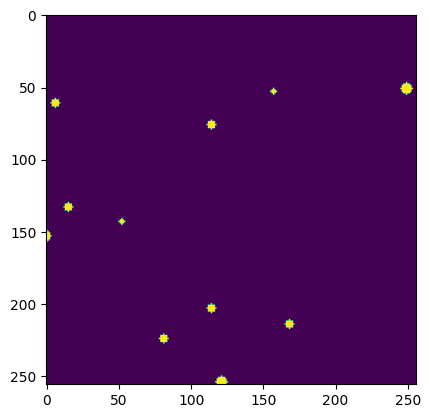

In [89]:
plt.imshow(gt_masks[0])

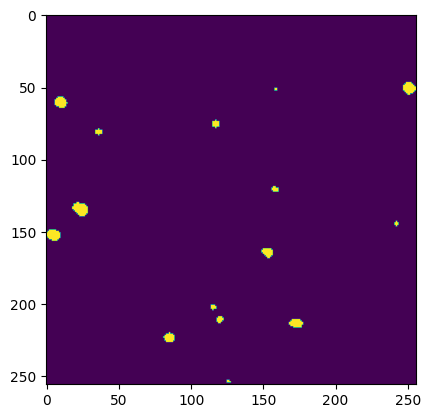

In [90]:
plt.imshow(pred_masks[0])